# Details of evaluation (what happens timeline)
# Details on interpolation (What's supported, how to define it)
# Details on caching
# Node types? 
## Data source
## Algorithm
## Compositor



#  Example of automatic interpolation

Once the dataset is read through PODPAC, it can be re-interpolated automatically to a different coordinate system.

The default interpolation scheme is nearest-neighbor. 

Let's read **a subset of the SMAP data**, using nearest-neighbor interpolation **at the resolution of the SRTM file**.

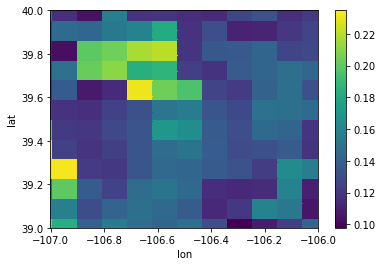

In [9]:
o = smap.eval(srtm.native_coordinates)
o.plot()
pass

In [10]:
# Note, the output is the same size as the SRTM data's native coordinates
print(o.shape)
print(srtm.native_coordinates.shape)

(3601, 3601)
(3601, 3601)


## Alternate interpolation methods

Now let's use bilinear interpolation at the resolution of the SRTM file. 

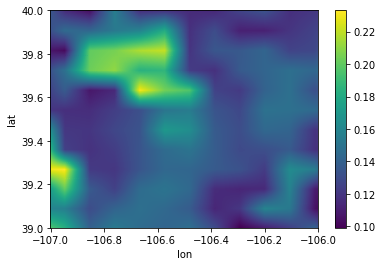

In [11]:
smap.interpolation = 'bilinear'
o = smap.eval(srtm.native_coordinates)
o.plot()
pass

# Exercises
